# Module 19: Visualizing Neural Networks

**Understanding What's Inside the Black Box**

---

## Objectives

By the end of this notebook, you will:
- Visualize weights and their evolution during training
- Plot activations at each layer
- Monitor gradient flow to detect vanishing/exploding gradients
- Visualize decision boundaries
- Create embedding visualizations with t-SNE
- Understand saliency maps and feature attribution

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import make_moons, make_circles

torch.manual_seed(42)
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

---

# Part 1: Weight Visualization

---

## 1.1 Visualizing Weight Distributions

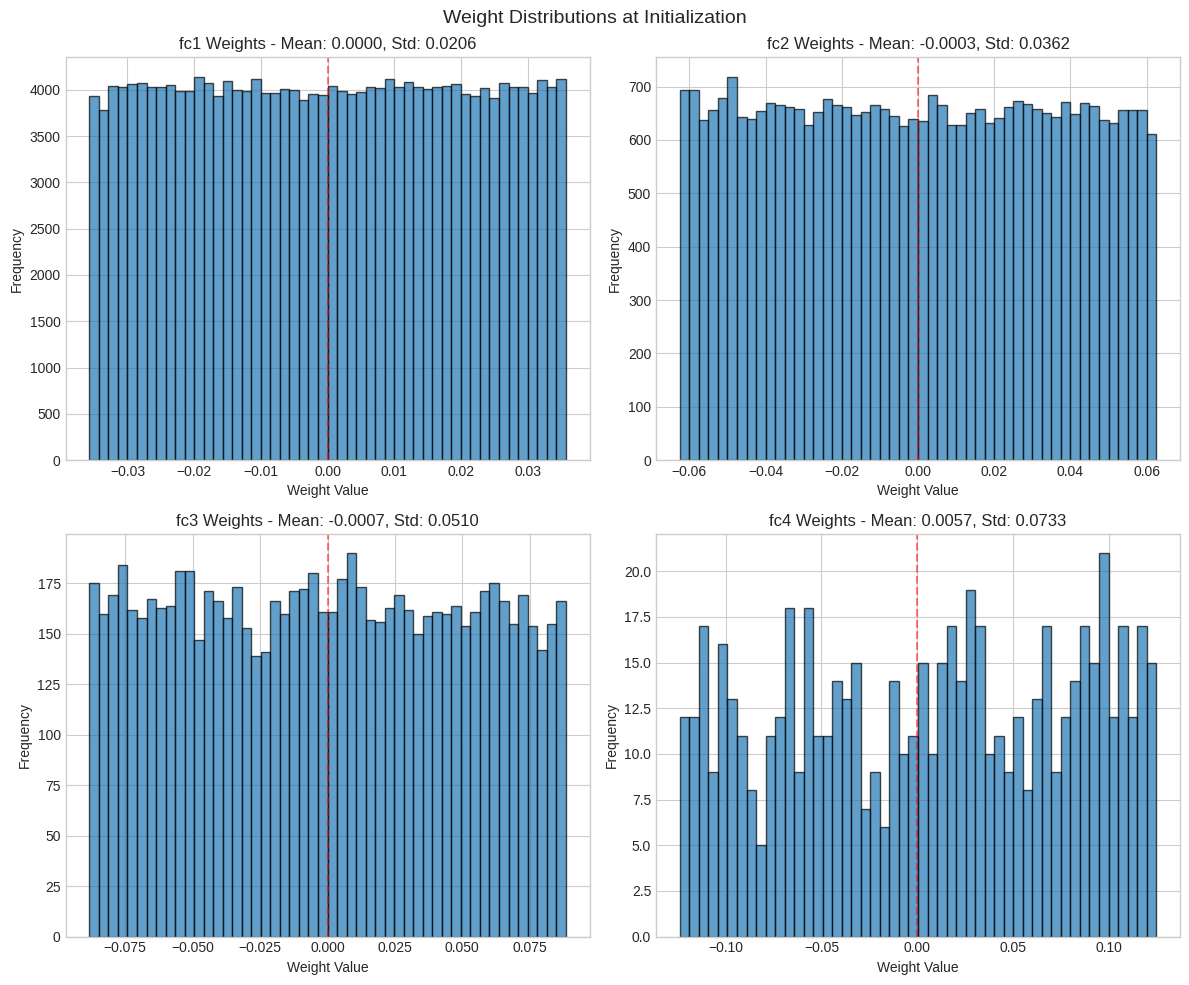

In [2]:
# Create a simple network
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

model = SimpleNet()

# Plot weight distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
layers = [model.fc1, model.fc2, model.fc3, model.fc4]
layer_names = ['fc1', 'fc2', 'fc3', 'fc4']

for ax, layer, name in zip(axes.flat, layers, layer_names):
    weights = layer.weight.detach().numpy().flatten()
    ax.hist(weights, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'{name} Weights - Mean: {weights.mean():.4f}, Std: {weights.std():.4f}')
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Frequency')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Weight Distributions at Initialization', fontsize=14)
plt.tight_layout()
plt.show()

## 1.2 Weights as Heatmaps

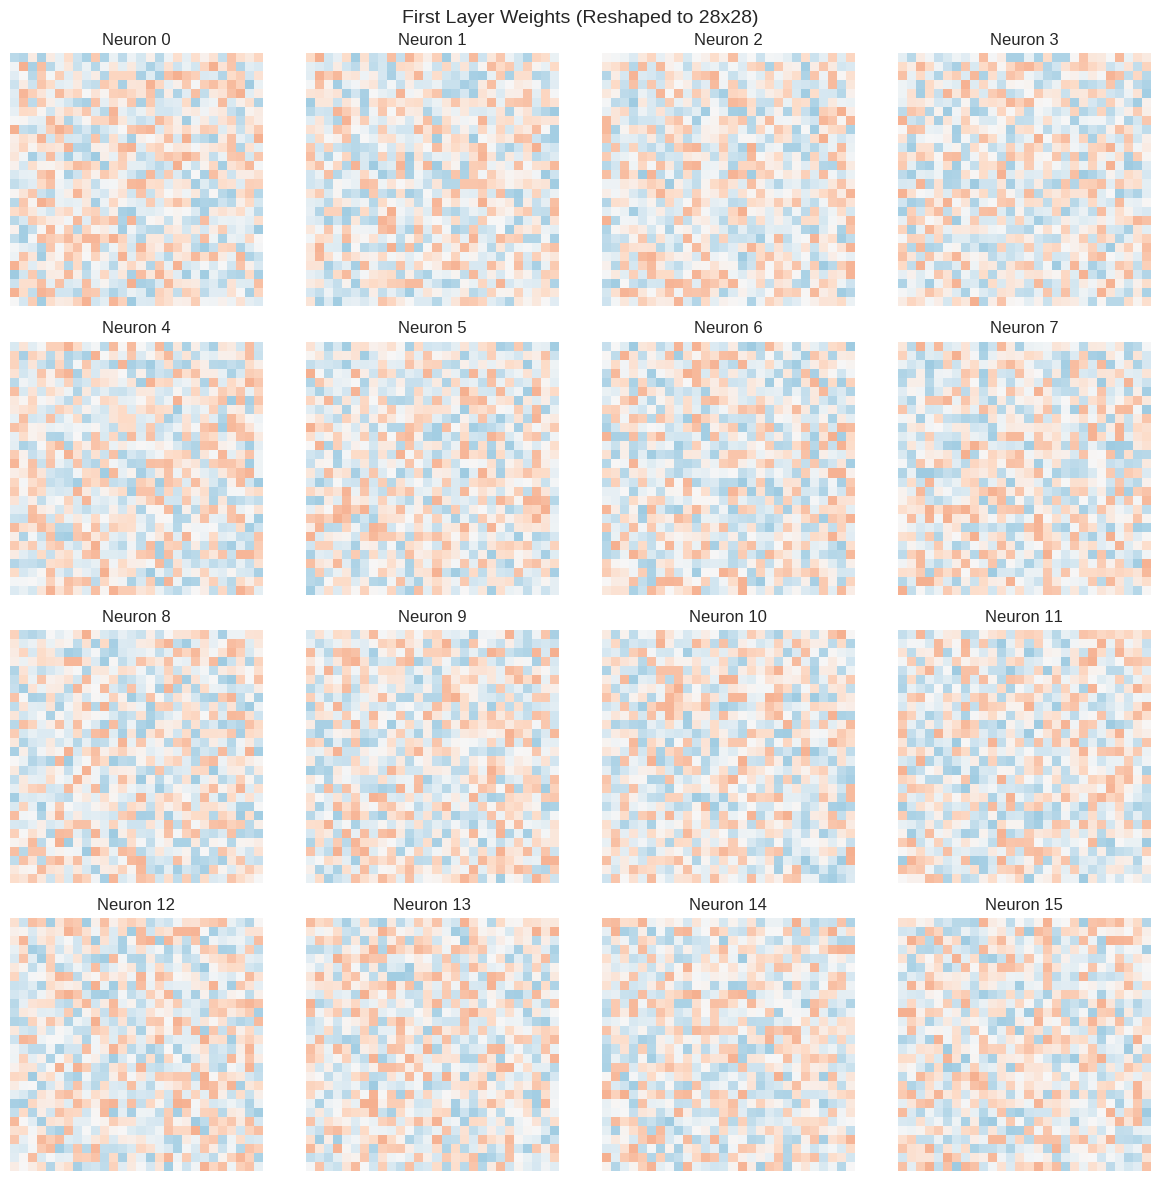

In [3]:
# Visualize first layer weights as heatmap (first 16 neurons)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    # Reshape weights to 28x28 (image shape)
    weights = model.fc1.weight[i].detach().numpy().reshape(28, 28)
    im = ax.imshow(weights, cmap='RdBu', vmin=-0.1, vmax=0.1)
    ax.set_title(f'Neuron {i}')
    ax.axis('off')

plt.suptitle('First Layer Weights (Reshaped to 28x28)', fontsize=14)
plt.tight_layout()
plt.show()

## 1.3 Weight Evolution During Training

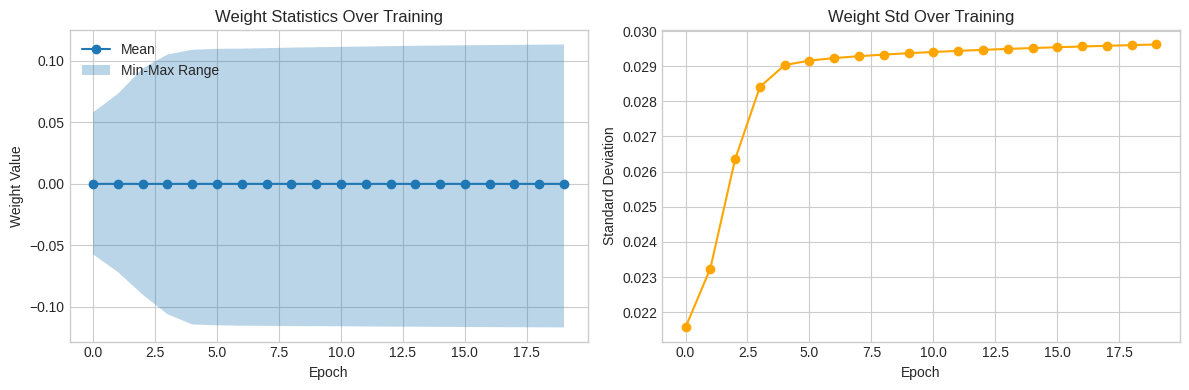

In [4]:
# Generate synthetic data
X = torch.randn(1000, 784)
y = torch.randint(0, 10, (1000,))
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = SimpleNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Track weight statistics over epochs
weight_stats = {'mean': [], 'std': [], 'max': [], 'min': []}

for epoch in range(20):
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()

    # Record statistics for fc1
    w = model.fc1.weight.detach().numpy().flatten()
    weight_stats['mean'].append(w.mean())
    weight_stats['std'].append(w.std())
    weight_stats['max'].append(w.max())
    weight_stats['min'].append(w.min())

# Plot evolution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(weight_stats['mean'], label='Mean', marker='o')
axes[0].fill_between(range(20), weight_stats['min'], weight_stats['max'], alpha=0.3, label='Min-Max Range')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Weight Value')
axes[0].set_title('Weight Statistics Over Training')
axes[0].legend()

axes[1].plot(weight_stats['std'], marker='o', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title('Weight Std Over Training')

plt.tight_layout()
plt.show()

---

# Part 2: Activation Visualization

---

## 2.1 Hooking into Activations

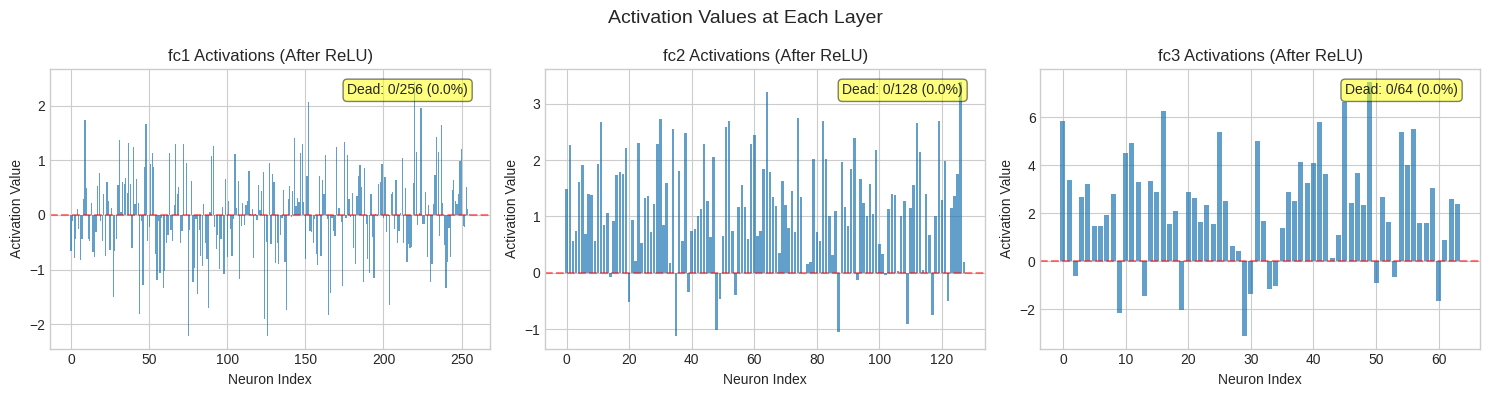

In [5]:
# Store activations using hooks
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
model.fc1.register_forward_hook(get_activation('fc1'))
model.fc2.register_forward_hook(get_activation('fc2'))
model.fc3.register_forward_hook(get_activation('fc3'))

# Forward pass
sample = torch.randn(1, 784)
_ = model(sample)

# Visualize activations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, act) in zip(axes, activations.items()):
    act_values = act.numpy().flatten()
    ax.bar(range(len(act_values)), act_values, alpha=0.7)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f'{name} Activations (After ReLU)')
    ax.set_xlabel('Neuron Index')
    ax.set_ylabel('Activation Value')

    # Count dead neurons (always 0)
    dead = (act_values == 0).sum()
    total = len(act_values)
    ax.text(0.95, 0.95, f'Dead: {dead}/{total} ({100*dead/total:.1f}%)',
            transform=ax.transAxes, ha='right', va='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.suptitle('Activation Values at Each Layer', fontsize=14)
plt.tight_layout()
plt.show()

## 2.2 Activation Distribution Across Batch

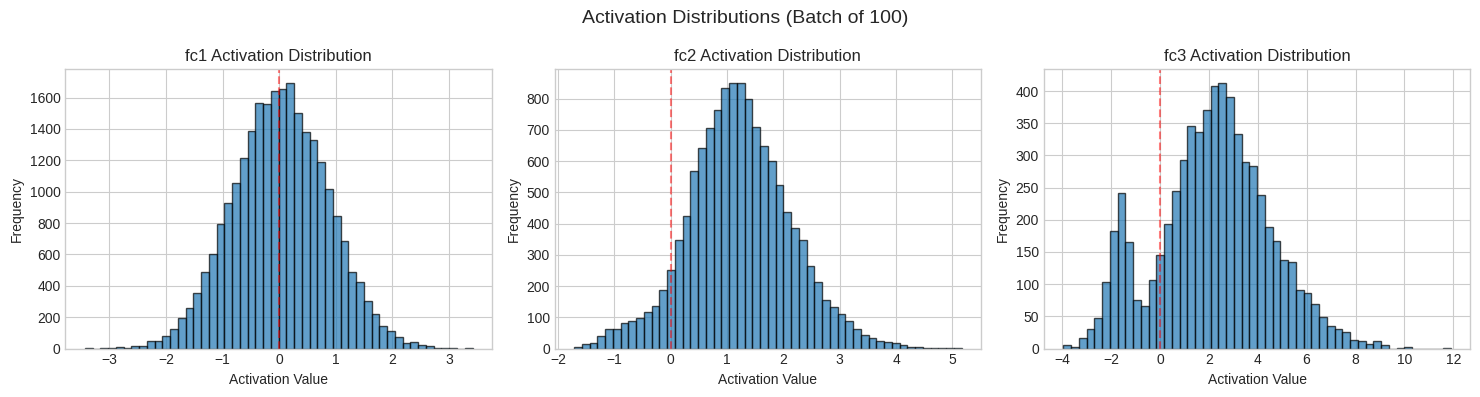

In [6]:
# Forward pass with batch
batch = torch.randn(100, 784)
_ = model(batch)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, act) in zip(axes, activations.items()):
    act_values = act.numpy().flatten()
    ax.hist(act_values, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f'{name} Activation Distribution')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')

plt.suptitle('Activation Distributions (Batch of 100)', fontsize=14)
plt.tight_layout()
plt.show()

---

# Part 3: Gradient Flow Visualization

---

## 3.1 Gradient Magnitudes Per Layer

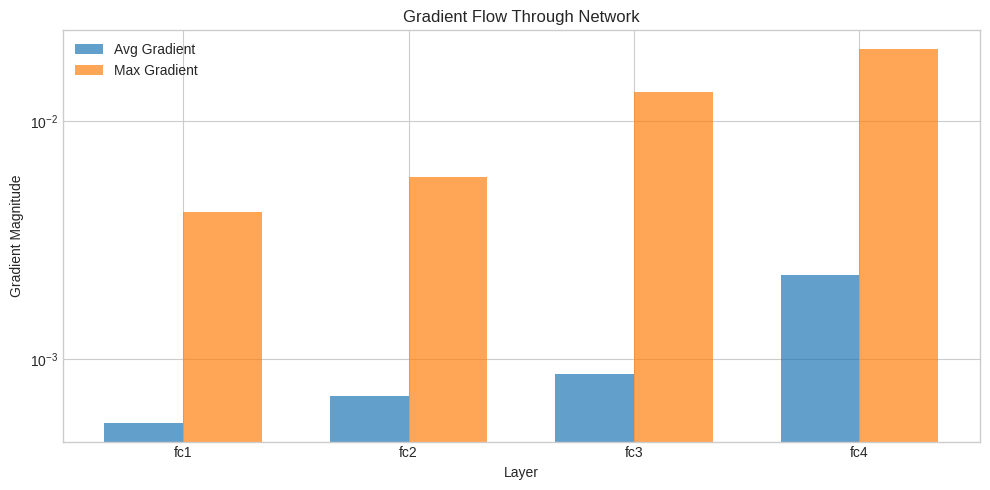

In [7]:
def plot_gradient_flow(model):
    """Visualize gradient magnitudes for each layer."""
    layers = []
    avg_grads = []
    max_grads = []

    for name, param in model.named_parameters():
        if param.grad is not None and 'weight' in name:
            layers.append(name.replace('.weight', ''))
            avg_grads.append(param.grad.abs().mean().item())
            max_grads.append(param.grad.abs().max().item())

    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(layers))
    width = 0.35

    ax.bar(x - width/2, avg_grads, width, label='Avg Gradient', alpha=0.7)
    ax.bar(x + width/2, max_grads, width, label='Max Gradient', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Gradient Magnitude')
    ax.set_title('Gradient Flow Through Network')
    ax.legend()
    ax.set_yscale('log')  # Log scale to see vanishing gradients

    plt.tight_layout()
    plt.show()

# Run a forward and backward pass
model = SimpleNet()
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_batch = torch.randn(32, 784)
y_batch = torch.randint(0, 10, (32,))

optimizer.zero_grad()
loss = criterion(model(X_batch), y_batch)
loss.backward()

plot_gradient_flow(model)

## 3.2 Detecting Vanishing Gradients

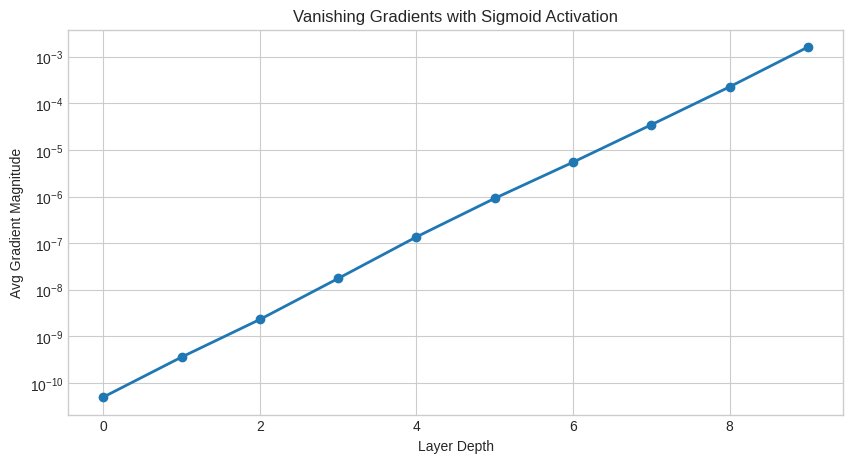

First layer gradient: 5.01e-11
Last layer gradient: 1.62e-03
Ratio: 3.09e-08x smaller!


In [8]:
# Deep network with sigmoid (prone to vanishing gradients)
class DeepSigmoidNet(nn.Module):
    def __init__(self, depth=10):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(nn.Linear(64, 64))
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        for layer in self.layers:
            x = torch.sigmoid(layer(x))  # Sigmoid causes vanishing gradients
        return self.output(x)

deep_model = DeepSigmoidNet(depth=10)
X = torch.randn(32, 64)
y = torch.randint(0, 10, (32,))

loss = criterion(deep_model(X), y)
loss.backward()

# Plot gradient magnitudes
grad_mags = []
for i, layer in enumerate(deep_model.layers):
    grad_mags.append(layer.weight.grad.abs().mean().item())

plt.figure(figsize=(10, 5))
plt.plot(grad_mags, marker='o', linewidth=2)
plt.xlabel('Layer Depth')
plt.ylabel('Avg Gradient Magnitude')
plt.title('Vanishing Gradients with Sigmoid Activation')
plt.yscale('log')
plt.grid(True)
plt.show()

print(f"First layer gradient: {grad_mags[0]:.2e}")
print(f"Last layer gradient: {grad_mags[-1]:.2e}")
print(f"Ratio: {grad_mags[0]/grad_mags[-1]:.2e}x smaller!")

---

# Part 4: Decision Boundary Visualization

---

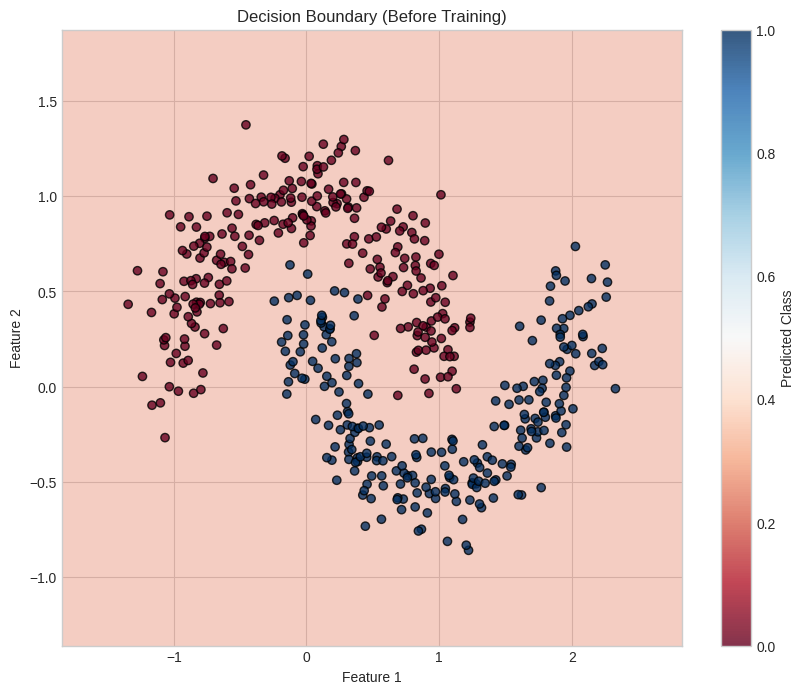

In [9]:
# Generate 2D classification data
X, y = make_moons(n_samples=500, noise=0.15, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Simple classifier
class Classifier2D(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2)
        )

    def forward(self, x):
        return self.net(x)

@torch.no_grad()
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    model.eval()

    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict on mesh
    mesh = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(mesh).argmax(dim=1).numpy().reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', alpha=0.8, edgecolors='black')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar(label='Predicted Class')
    plt.show()

# Train the model
clf = Classifier2D()
optimizer = optim.Adam(clf.parameters(), lr=0.01)

# Plot before training
plot_decision_boundary(clf, X, y, 'Decision Boundary (Before Training)')

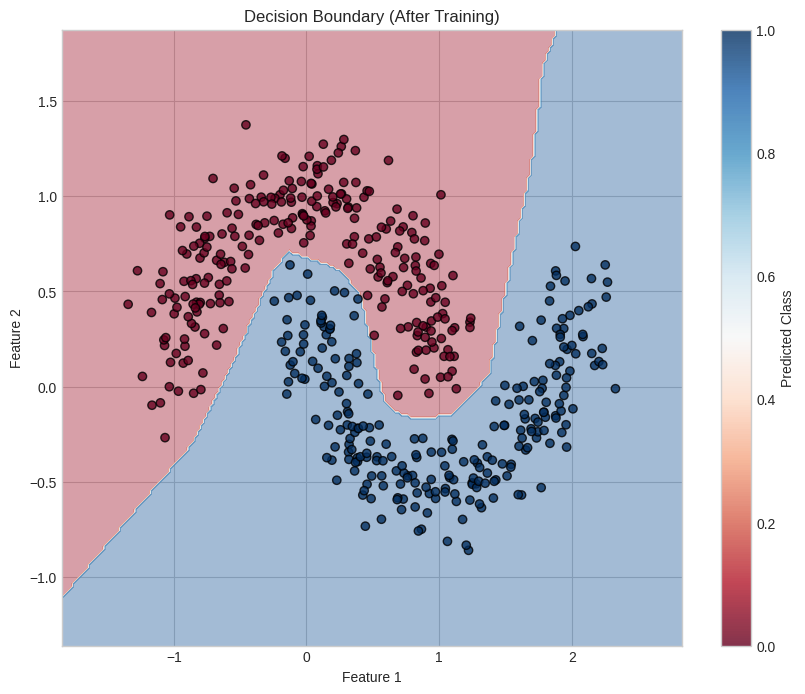

In [10]:
# Train
clf.train()
for epoch in range(200):
    optimizer.zero_grad()
    loss = nn.CrossEntropyLoss()(clf(X), y)
    loss.backward()
    optimizer.step()

# Plot after training
plot_decision_boundary(clf, X, y, 'Decision Boundary (After Training)')

## 4.1 Decision Boundary Evolution

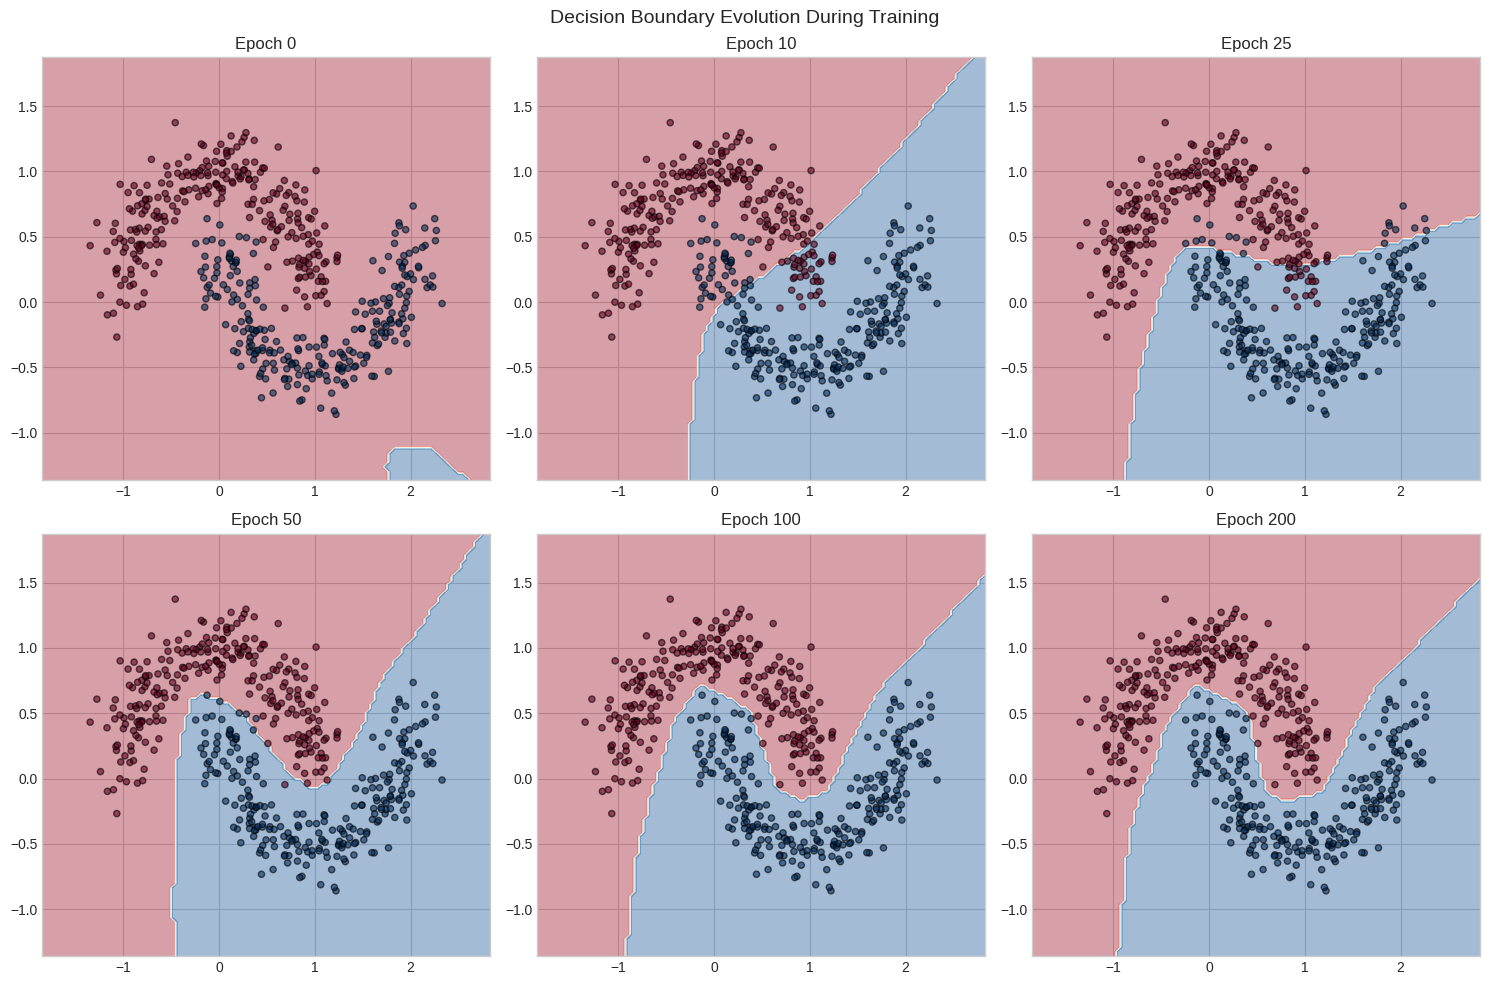

In [11]:
# Train and capture boundaries at different epochs
clf = Classifier2D()
optimizer = optim.Adam(clf.parameters(), lr=0.01)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
epochs_to_plot = [0, 10, 25, 50, 100, 200]

for ax, target_epoch in zip(axes.flat, epochs_to_plot):
    # Train up to target epoch
    if target_epoch > 0:
        clf.train()
        current = 0 if target_epoch == epochs_to_plot[0] else epochs_to_plot[epochs_to_plot.index(target_epoch) - 1]
        for _ in range(target_epoch - current):
            optimizer.zero_grad()
            loss = nn.CrossEntropyLoss()(clf(X), y)
            loss.backward()
            optimizer.step()

    # Plot
    clf.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    mesh = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    with torch.no_grad():
        Z = clf(mesh).argmax(dim=1).numpy().reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', alpha=0.6, edgecolors='black', s=20)
    ax.set_title(f'Epoch {target_epoch}')

plt.suptitle('Decision Boundary Evolution During Training', fontsize=14)
plt.tight_layout()
plt.show()

---

# Part 5: Embedding Visualization with t-SNE

---

In [12]:
# Generate multi-class data
from sklearn.datasets import make_blobs

X_blobs, y_blobs = make_blobs(n_samples=500, centers=5, n_features=20, random_state=42)
X_blobs = torch.tensor(X_blobs, dtype=torch.float32)
y_blobs = torch.tensor(y_blobs, dtype=torch.long)

# Network that we'll use to extract embeddings
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)  # Embedding layer
        )
        self.classifier = nn.Linear(16, 5)

    def forward(self, x):
        embedding = self.encoder(x)
        return self.classifier(embedding)

    def get_embedding(self, x):
        return self.encoder(x)

emb_net = EmbeddingNet()

# Train the network
optimizer = optim.Adam(emb_net.parameters(), lr=0.01)
for epoch in range(100):
    optimizer.zero_grad()
    loss = nn.CrossEntropyLoss()(emb_net(X_blobs), y_blobs)
    loss.backward()
    optimizer.step()

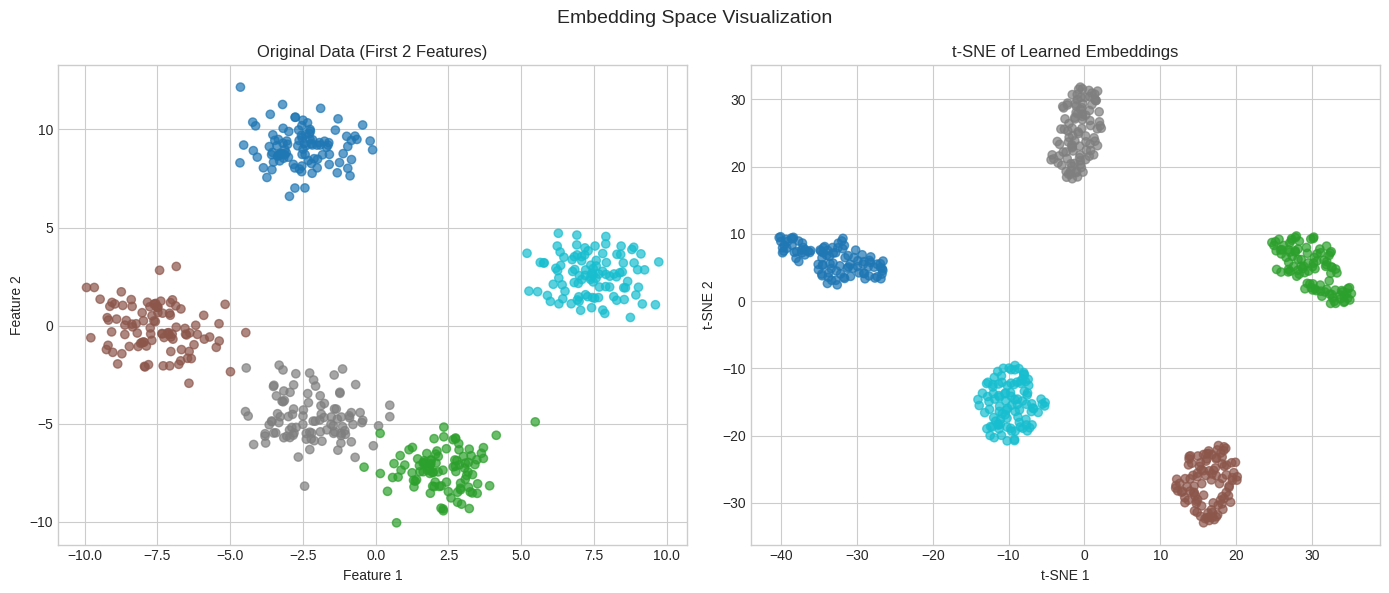

In [13]:
# Extract embeddings and visualize with t-SNE
emb_net.eval()
with torch.no_grad():
    embeddings = emb_net.get_embedding(X_blobs).numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original data (first 2 dimensions)
axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='tab10', alpha=0.7)
axes[0].set_title('Original Data (First 2 Features)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# t-SNE of learned embeddings
axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_blobs.numpy(), cmap='tab10', alpha=0.7)
axes[1].set_title('t-SNE of Learned Embeddings')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')

plt.suptitle('Embedding Space Visualization', fontsize=14)
plt.tight_layout()
plt.show()

---

# Part 6: Saliency Maps (Gradient-Based Attribution)

---

## What does the model focus on?

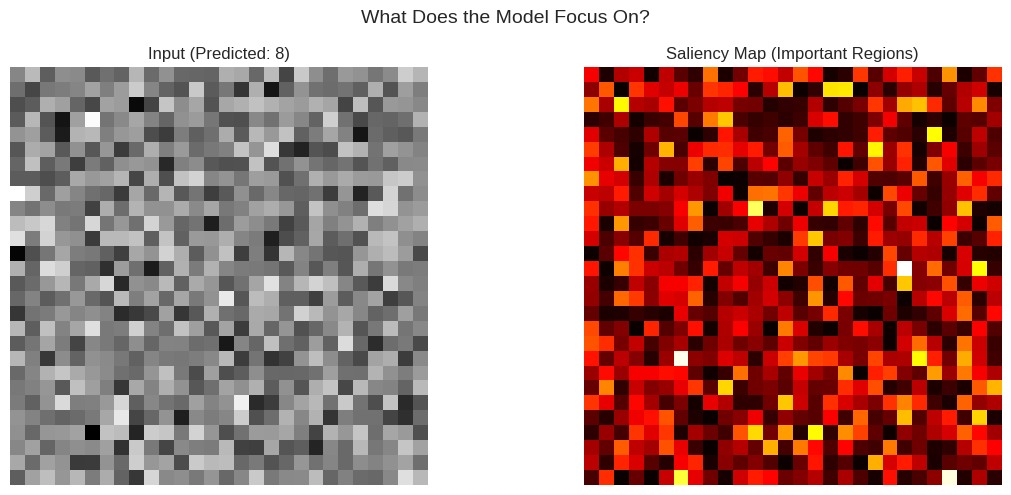

In [14]:
def compute_saliency(model, X, target_class):
    """
    Compute saliency map: gradient of output w.r.t. input.
    Shows which input features are most important.
    """
    X = X.clone().requires_grad_(True)

    # Forward pass
    output = model(X)

    # Get score for target class
    score = output[0, target_class]

    # Backward pass
    score.backward()

    # Saliency is the absolute value of gradients
    saliency = X.grad.abs()

    return saliency.detach().numpy()

# Create a simple image classifier
model = SimpleNet()

# Create a sample "image" (28x28 flattened)
sample_image = torch.randn(1, 784)

# Get prediction
with torch.no_grad():
    pred = model(sample_image).argmax().item()

# Compute saliency
saliency = compute_saliency(model, sample_image, pred)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(sample_image.reshape(28, 28), cmap='gray')
axes[0].set_title(f'Input (Predicted: {pred})')
axes[0].axis('off')

axes[1].imshow(saliency.reshape(28, 28), cmap='hot')
axes[1].set_title('Saliency Map (Important Regions)')
axes[1].axis('off')

plt.suptitle('What Does the Model Focus On?', fontsize=14)
plt.tight_layout()
plt.show()

---

# Part 7: Training Dynamics

---

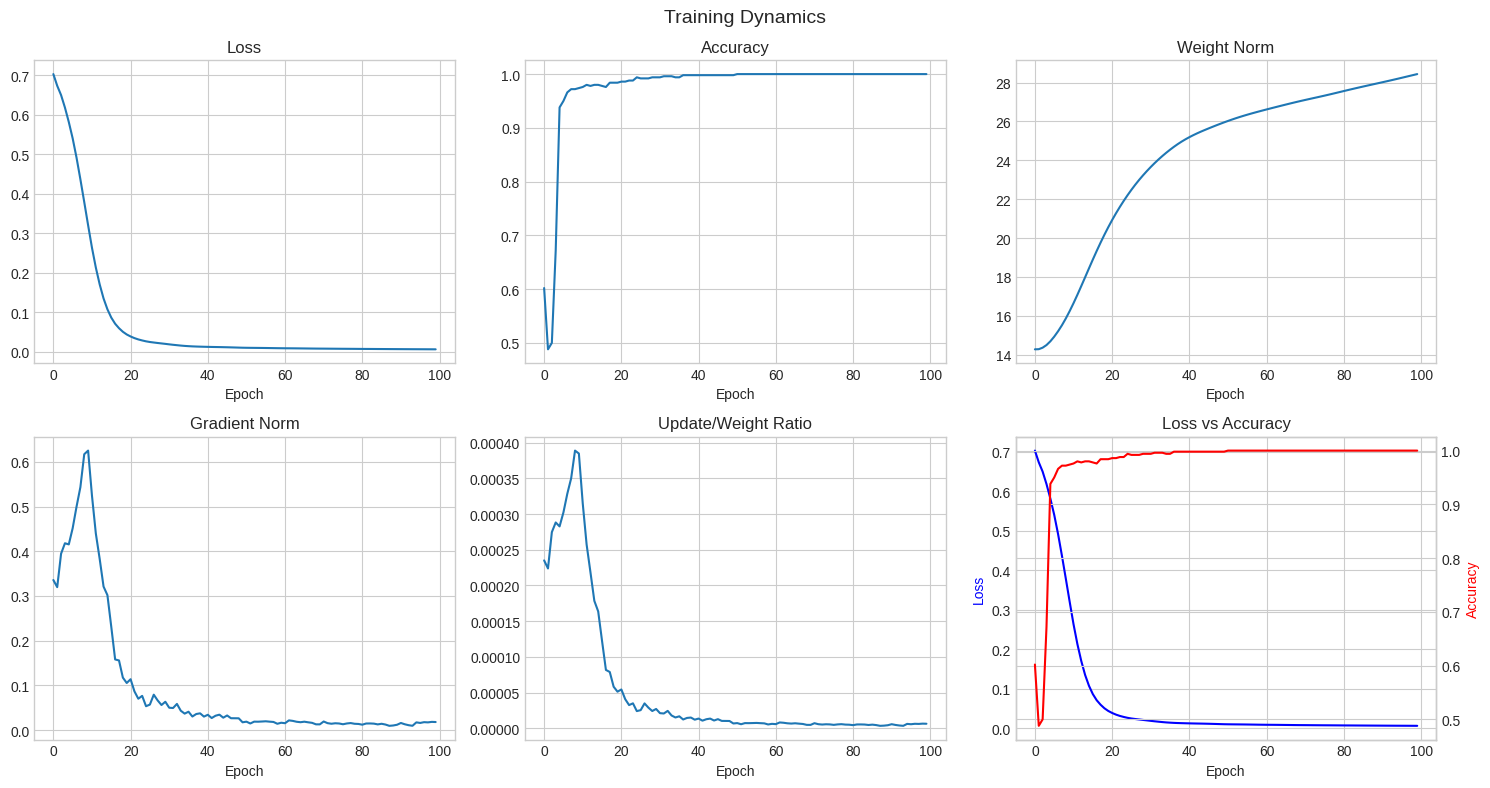

In [15]:
# Track comprehensive training metrics
X, y = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

model = Classifier2D(hidden_size=64)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Tracking
history = {
    'loss': [],
    'accuracy': [],
    'weight_norm': [],
    'grad_norm': [],
    'update_ratio': []  # Update magnitude / weight magnitude
}

for epoch in range(100):
    optimizer.zero_grad()

    # Forward
    output = model(X)
    loss = nn.CrossEntropyLoss()(output, y)

    # Metrics before backward
    with torch.no_grad():
        acc = (output.argmax(dim=1) == y).float().mean().item()
        weight_norm = sum(p.norm().item() for p in model.parameters())

    # Backward
    loss.backward()

    # Gradient norm
    grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)

    # Update
    optimizer.step()

    # Store
    history['loss'].append(loss.item())
    history['accuracy'].append(acc)
    history['weight_norm'].append(weight_norm)
    history['grad_norm'].append(grad_norm)
    history['update_ratio'].append(grad_norm / weight_norm * 0.01)  # lr = 0.01

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].plot(history['loss'])
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')

axes[0, 1].plot(history['accuracy'])
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')

axes[0, 2].plot(history['weight_norm'])
axes[0, 2].set_title('Weight Norm')
axes[0, 2].set_xlabel('Epoch')

axes[1, 0].plot(history['grad_norm'])
axes[1, 0].set_title('Gradient Norm')
axes[1, 0].set_xlabel('Epoch')

axes[1, 1].plot(history['update_ratio'])
axes[1, 1].set_title('Update/Weight Ratio')
axes[1, 1].set_xlabel('Epoch')

# Loss vs Accuracy
ax2 = axes[1, 2].twinx()
axes[1, 2].plot(history['loss'], 'b-', label='Loss')
ax2.plot(history['accuracy'], 'r-', label='Accuracy')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss', color='b')
ax2.set_ylabel('Accuracy', color='r')
axes[1, 2].set_title('Loss vs Accuracy')

plt.suptitle('Training Dynamics', fontsize=14)
plt.tight_layout()
plt.show()

---

# Part 8: Layer-wise Representation Analysis

---

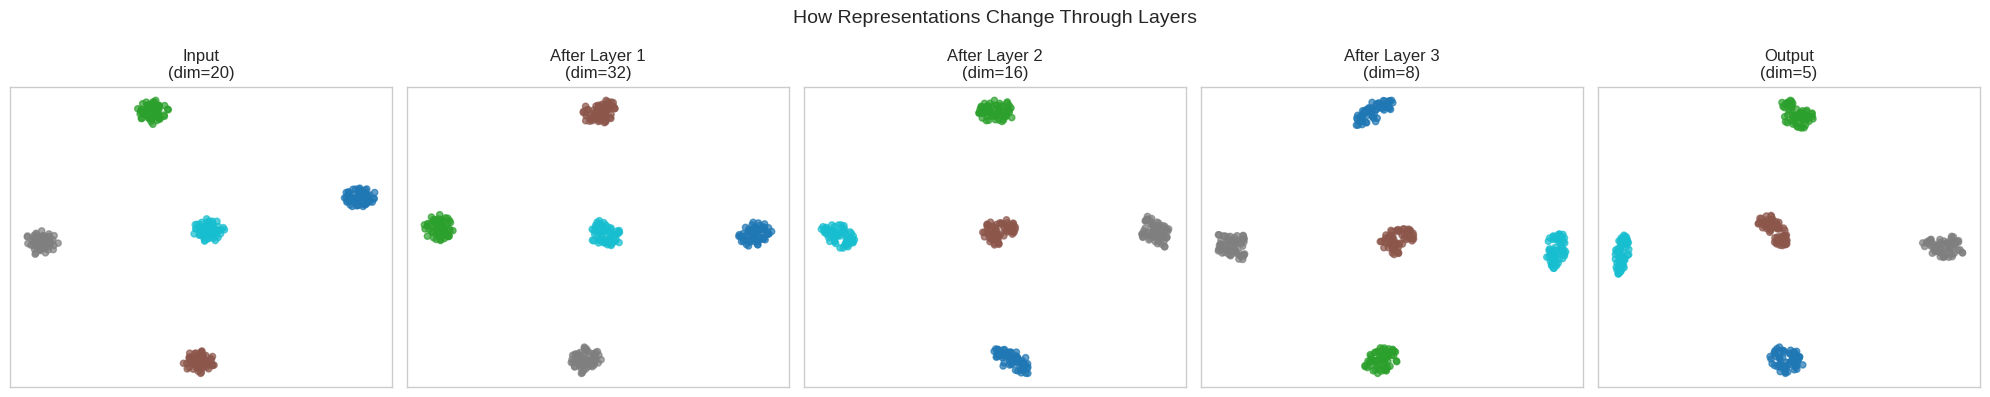

In [16]:
# How does representation change through layers?
class AnalyzableNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(20, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 8),
            nn.Linear(8, 5)
        ])
        self.relu = nn.ReLU()

    def forward(self, x):
        intermediates = [x]
        for i, layer in enumerate(self.layers[:-1]):
            x = self.relu(layer(x))
            intermediates.append(x)
        x = self.layers[-1](x)
        intermediates.append(x)
        return x, intermediates

# Generate data and train
X, y = make_blobs(n_samples=300, centers=5, n_features=20, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

net = AnalyzableNet()
optimizer = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    output, _ = net(X)
    loss = nn.CrossEntropyLoss()(output, y)
    loss.backward()
    optimizer.step()

# Get intermediate representations
net.eval()
with torch.no_grad():
    _, intermediates = net(X)

# Visualize each layer's representation with t-SNE
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
layer_names = ['Input', 'After Layer 1', 'After Layer 2', 'After Layer 3', 'Output']

for ax, inter, name in zip(axes, intermediates, layer_names):
    inter_np = inter.numpy()

    # Apply t-SNE if dimension > 2
    if inter_np.shape[1] > 2:
        perp = min(30, len(inter_np) - 1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=perp)
        inter_2d = tsne.fit_transform(inter_np)
    else:
        inter_2d = inter_np[:, :2] if inter_np.shape[1] >= 2 else np.column_stack([inter_np, np.zeros(len(inter_np))])

    ax.scatter(inter_2d[:, 0], inter_2d[:, 1], c=y.numpy(), cmap='tab10', alpha=0.7, s=20)
    ax.set_title(f'{name}\n(dim={inter_np.shape[1]})')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('How Representations Change Through Layers', fontsize=14)
plt.tight_layout()
plt.show()

---

# Summary: What Can We Visualize?

---

| Stage | What to Visualize | Purpose |
|-------|-------------------|----------|
| **Weights** | Distributions, heatmaps, evolution | Check initialization, detect issues |
| **Activations** | Per-layer distributions, dead neurons | Detect ReLU death, saturation |
| **Gradients** | Magnitude per layer | Detect vanishing/exploding |
| **Decision Boundary** | 2D classification regions | Understand model behavior |
| **Embeddings** | t-SNE/UMAP of hidden layers | See if classes separate |
| **Saliency** | Input feature importance | Explain predictions |
| **Training Dynamics** | Loss, accuracy, norms | Monitor training health |

---

# Interview Tips

---

**Q: How would you debug a neural network that's not learning?**

A:
1. Check gradient flow – are gradients vanishing/exploding?
2. Visualize activations – are neurons dead (all zeros after ReLU)?
3. Check weight distributions – are they reasonable?
4. Monitor loss curve – is it decreasing at all?
5. Verify data pipeline – is data being loaded correctly?

**Q: How do you know if your model is learning meaningful features?**

A:
1. Visualize embeddings with t-SNE – classes should cluster
2. Check saliency maps – model should focus on relevant regions
3. Plot decision boundaries – should match data structure

**Q: What causes vanishing gradients?**

A: Sigmoid/tanh activations squash gradients to near-zero for large inputs. Solution: Use ReLU, proper initialization (He/Xavier), residual connections, or batch normalization.

---

## Back to: [README](../README.md)